<a href="https://colab.research.google.com/github/mohammedterry/ANNs/blob/master/BERT_frozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert (Frozen) / Embeddings


In [3]:
!pip3 install pytorch_pretrained_bert

from pytorch_pretrained_bert import BertTokenizer
tokeniser = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)

from pytorch_pretrained_bert import BertModel
bert = BertModel.from_pretrained('bert-large-uncased')

import torch

     |████████████████████████████████| 133kB 2.8MB/s 


100%|██████████| 1248501532/1248501532 [00:24<00:00, 50557876.93B/s]


In [95]:
sentence = "this is a test"
tokenised_sentence = ["[CLS]"] + tokeniser.tokenize(sentence) +  ["[SEP]"]
print(tokenised_sentence)
tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
print(tokens_tensor)
segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
encoded_layers, _ = bert(tokens_tensor, segments_tensor)
len(encoded_layers)

['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']
tensor([[ 101, 2023, 2003, 1037, 3231,  102]])


24

## Combining multiple word vectors into a single vector

using final (24th) hidden layer as example - one vec per word, each with 1024 dimensions


In [96]:
print(encoded_layers[-1].shape)
encoded_layers[-1][0]

torch.Size([1, 6, 1024])


tensor([[-0.4665, -0.3775, -0.6638,  ...,  0.1361,  0.5160,  0.0705],
        [-0.1793, -0.1920, -0.2831,  ..., -0.3865,  0.4590,  0.0127],
        [-0.4999,  0.0956, -0.3832,  ..., -0.3222,  0.2968,  0.3539],
        [-0.6077, -0.2828, -0.2071,  ..., -0.0763,  0.2473,  0.2906],
        [-0.3770,  0.1065,  0.1112,  ...,  0.1929,  0.4056,  0.1685],
        [-0.2457, -0.3538, -0.3710,  ..., -0.3502,  0.4159,  0.2079]],
       grad_fn=<SelectBackward>)

**Method 1: Final state**

In [97]:
final_state = encoded_layers[-1][0][-1]
print(final_state.shape)
final_state

torch.Size([1024])


tensor([-0.2457, -0.3538, -0.3710,  ..., -0.3502,  0.4159,  0.2079],
       grad_fn=<SelectBackward>)

**Method 2: Sum pool**

In [98]:
sumpool = torch.sum(encoded_layers[-1][0],0) 
print(sumpool.shape)
sumpool

torch.Size([1024])


tensor([-2.3763, -1.0040, -1.7970,  ..., -0.8062,  2.3407,  1.1042],
       grad_fn=<SumBackward2>)

**Method 3: Mean pool**

In [99]:
meanpool = torch.mean(encoded_layers[-1][0],0)
print(meanpool.shape)
meanpool

torch.Size([1024])


tensor([-0.3960, -0.1673, -0.2995,  ..., -0.1344,  0.3901,  0.1840],
       grad_fn=<MeanBackward2>)

**Method 4: concatenation of above methods**

![alt text](https://cdn-images-1.medium.com/max/1600/1*AZdaco3CsoBILy4_-ys8Cw.png)

In [100]:
sentence_vector = torch.cat((final_state, sumpool, meanpool), 0)
print(sentence_vector.shape)
sentence_vector

torch.Size([3072])


tensor([-0.2457, -0.3538, -0.3710,  ..., -0.1344,  0.3901,  0.1840],
       grad_fn=<CatBackward>)

## Which hidden layer to take?


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

Lets get the sentence vector representation for each of the 24 hidden layers (the above was only for the final hidden layer)

In [0]:
def sentence_vector(hiddenlayer_tensor):
  final = hiddenlayer_tensor[-1]
  sumpool = torch.sum(hiddenlayer_tensor,0) 
  meanpool = torch.mean(hiddenlayer_tensor,0)
  return torch.cat((final,sumpool,meanpool),0)

In [102]:
layer_wise_sentence_vectors = [sentence_vector(hiddenlayer[0]) for hiddenlayer in encoded_layers]
len(layer_wise_sentence_vectors)

24

**Method: Concatenation of all hidden layers**

![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

In [103]:
final_sentence_vector = torch.cat(layer_wise_sentence_vectors,0)
print(final_sentence_vector.shape)
final_sentence_vector

torch.Size([73728])


tensor([ 0.1078,  0.1644,  0.0335,  ..., -0.1344,  0.3901,  0.1840],
       grad_fn=<CatBackward>)

## Test

In [0]:
def bert_sentence_vector(sentence):
  tokenised_sentence = ["[CLS]"] + tokeniser.tokenize(sentence) +  ["[SEP]"]
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  hiddenlayers, _ = bert(tokens_tensor, segments_tensor)
  sentence_vectors = [sentence_vector(layer[0]) for layer in hiddenlayers]
  return torch.cat(sentence_vectors,0).detach().numpy()

In [105]:
v = bert_sentence_vector("this is a test")
print(v.shape)
v

(73728,)


array([ 0.01702598,  0.11345232,  0.0334793 , ..., -0.16942096,
       -0.00423936, -0.19679634], dtype=float32)

In [0]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 

def plot_clusters(words, svectors, clusters):
  pca = PCA(n_components=3)
  principalComponents = pca.fit_transform(svectors)
  
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y','z'])

  sns.set_style("whitegrid")
  palette = sns.color_palette("husl", max(set(clusters))+1) + ['grey']
  dataframe['colour'] = pd.Series([palette[i] for i in clusters])
  
  fig = plt.figure()
  graph = Axes3D(fig)
  [graph.text(x, z, y, s, 'x', color = c) for x, y, z, s, c in zip(dataframe['x'], dataframe['y'], dataframe['z'], words, dataframe['colour'])]
  graph.set_xlim(min(dataframe['x']), max(dataframe['x']))
  graph.set_ylim(min(dataframe['z']), max(dataframe['z']))
  graph.set_zlim(min(dataframe['y']), max(dataframe['y']))
  plt.show()
  
  graph2=sns.regplot(data=dataframe, x="x", y="y", fit_reg=False, marker="+")
  [graph2.text(x, y, s,color=c) for x,y,s,c in zip(dataframe['x'],dataframe['y'],words,dataframe["colour"])]

In [0]:
r = 4
sentences = ["this is a test"]*r + ["this is an exam"]*r + ["i have a pet dog"]*r + ["i have a cat"]*r + ["i dont like animals"]*r + ["i love pets"]*r
idx_sentences = dict(enumerate(set(sentences)))
sentences_idx = {s:i for i,s in idx_sentences.items()}
topics = [sentences_idx[s] for s in sentences]
vectors = [bert_sentence_vector(s) for s in sentences]

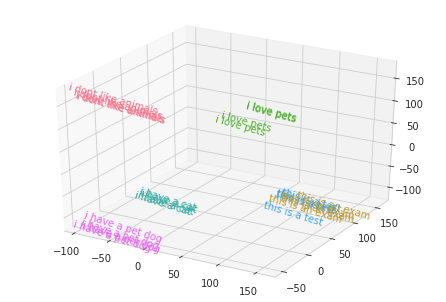

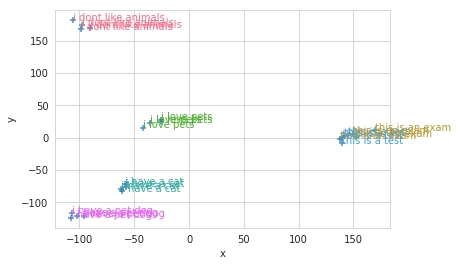

In [9]:
plot_clusters(sentences, vectors, topics)